# Project 2 Draft 8

11/4/2018

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

# Question:
Our question asked, if given a budget, what is the most effective combination of mosquito nets and vaccines that an organization could purchase in order to minimize the number of people infected with malaria. Malaria vaccines are being developed and tested, but have not yet been deployed on a large scale. Our model would help charities and other organizations determine how much money it is worth investing into vaccines by comparing them to the already existing mosquito nets. 


# Model:
This model is based off a paper that models the interaction of Malaria with the gene for Sickle Cell Disease. When an individual is homozygous for Sickle Cell Disease (SS), they have the disorder, which is a strong genetic disadvantage. Individuals who are heterozygous for Sickle Cell Disease (AS) do not have the disorder, but they do have an increased resistance to malaria. We thought it was very interesting how the population of people with the AS genotype impacted the dynamics of Malaria, so we decided to base our model off of this particular paper. 

The main state variables involved in the model are the number of susceptible people for both genotypes, the number of infected people for both genotypes, and the number of mosquitoes for both genotypes. There are several system variables that affect the model and presenting each here would be rather repetitive and unprecedented. Thus, the meaning of each system variable is presented with further clarity and detail in the comments of the code.

In order to answer our question, we researched the cost and effectiveness of vaccines and mosquito nets. We found that mosquito nets are 5 dollars and 50 percent effective and that vaccines are 20 dollars and 36 percent effective. We calculated the overall effectiveness per 1000 dollars by multiplying the cost and effectiveness together, then multiplying the product by 1000 dollars, and then dividing that product by the human population of the model (40,000,000 people). Then, we added some equations into our update function that modified the infection rate and mosquito biting rate using the effectiveness per 1000 dollars in thousands of dollars. The modified values for infection rate and mosquito biting rate are then plugged into the equations from the paper which calculate the change in infected and susceptible populations over time. 

### Make System Function
This function creates a system with all the values used in the update function. It also initializes the state. The comments below go into more detail about the meaning of each value. 

In [10]:
def make_system(t0, t_end, dt, 
                a, 
                rN, 
                Nh, 
                θ1, 
                θ2, 
                rV, 
                φ1, 
                φ2, 
                λh1, 
                λh2, 
                λm1, 
                λm2, 
                δm, 
                c, 
                μ1, 
                μ2, 
                ν, 
                α1, 
                α2, 
                γ1, 
                γ2, 
                bNh,
                w, 
                P1, 
                P2):
    
    
    init = State(S1=19.2e6, S2=14.4e6, I1=4.8e6, I2=1.6e6, M=0.8)

    """
    S1 = number of uninfected individuals with AA genotype
    S2 = number of uninfected individuals with AS genotype
    I1 = number of infected individuals with AA genotype
    I2 = number of infected individuals with AS genotype
    M = Proportion of mosquitoes with plasmodium parasite
    """

    system = System(t0=0, t_end=200, dt = 1, init = init, 
#state variable
                      a = a, 
#Biting rate per human per mosquito.
                      rN = rN, 
#Decrease in biting rate per $1,000 spent on mosquito nets
                      Nh = Nh, 
#=S1 + S2 + I1 + I2 ; Total human population
                      θ1 = θ1, 
#Probability that an individual acquires plasmodium per bite type AA
                      θ2 = θ2, 
#Probability that an individual acquires plasmodium per bite type AS
                      rV = rV, 
#Decrease in probability of infection per $1,000 spent on vaccines
                      φ1 = φ1, 
#Probability mosquito gets infected from biting infected individual type AA
                      φ2 = φ2, 
#Probability mosquito gets infected from biting infected individual type AS
                      λh1 = λh1, 
# = aθ1(Im/Nh), Im = 1e15 x 0.8, Human infection rate AA
                      λh2 = λh2, 
# = aθ2(Im/Nh), Im = 1e15 x 0.8, Human infenction rate AS
                      λm1 = λm1, 
# = aφ1(I1+I2 +εR)/Nh, Mosquito infection rate from AA
                      λm2 = λm2, 
# = aφ1(I1+I2 +εR)/Nh, Mosquito infection rate from AS
                      δm = δm, 
#Mortality rate of mosquitoes
                      c = c, 
#Ratio of mosquitoes to human.
                      μ1 = μ1, 
#Human natural mortality rate
                      μ2 = μ2, 
#Human natural mortality rate + mortality rate due to sickle cell complications
                      ν = ν, 
#Extra mortality due to sickle cell gene complications
                      α1 = α1, 
#Malaria-induced mortality rate for genotype AA
                      α2 = α2, 
#Malaria-induced mortality rate for genotype AS
                      γ1 = γ1, 
#Recovery rate from malaria for genotype AA
                      γ2 = γ2, 
#Recovery rate from malaria for genotype AS
                      bNh = bNh,
#Per capita birth rate of humans b(1 − Nh/K), b = 0.00004, K = 10000 (per year)
                      w = w, 
#Fraction of AS individuals w- 0.1, w = 0.7, which one to use? w = 0.4
                      P1 = P1, 
#Fraction of the total birth of individuals of genotype AA = 0.64
                      P2 = P2
#Fraction of the total birth of individuals of genotype AS = 0.32
                   )
    
    return system

### Plot Results
This function takes the results of the simulation and plots them on a graph and labels the axes. 

In [11]:
def plot_results(results):
    """Plot the results for number of infected people with AA and AS Genotype.
    """
    plot(results.I1, '', label='AA Genotype')
    plot(results.I2, '', label='AS Genotype')
    decorate(xlabel='Time (days)',
             ylabel='Infected Population')

### Update Function
This function contains the equations from the model as well as the equations that we added. The equations that we added calculate new values for θ (infection rate per bite) and a (biting rate) based off the money spent on vaccines and nets respectively. The values rV and rN represent the effectiveness of vaccines, calculated by multiplying the number of nets or vaccines that $1000 will buy, multiplied by the effectiveness of each of the interventions, all divided by the number of humans in the simulation (Nh = 40,000,000).  

In [12]:
#updates the state variable and returns with its new values
def update_func(state, t, system, money_nets, money_vaccines): 
    s1, s2, i1, i2, m = state
    unpack(system)
    
    θ1a = θ1 * (1 - (rV * money_vaccines)) 
#calculates new chance likelihood of infection per bite (type AA) with vaccine
    θ2a = θ2 * (1 - (rV * money_vaccines))
#calculates new chance likelihood of infection per bite (type AS) with vaccine
    aa = a * (1 - (rN * money_nets))
#calculates new biting rate per human per mosquito with mosquito nets
    
    #functions from paper
    Nh = s1 + s2 + i1 + i2 #total population
    I_tot = i1 + i2 # sum of infected
    #These are the rates of infection for humans and mosquitoes
    λh1 = aa*θ1a*(m/Nh)
    λh2 = aa*θ2a*(m/Nh)
    λm1 = aa*φ1*(I_tot/Nh)
    λm2 = aa*φ2*(I_tot/Nh) 
    
#rates of change for susceptible & infected of both gene types and for mosquitoes
    dS1_dt = (P1*bNh*Nh - μ1*s1 - λh1*s1 + γ1*i1)*dt
    dS2_dt = (P2*bNh*Nh - μ2*s2 - λh2*s2 + γ2*i2)*dt
    dI1_dt = (λh1*s1 - (μ1 + γ1 + α1)*i1)*dt
    dI2_dt = (λh2*s2 - (μ2 + γ2 + α2)*i2)*dt
    dm_dt  = ((1 - m) * (λm1 + λm2) - δm)*dt
    
    #Adds change and stores new result to the state variable
    s1 += dS1_dt
    s2 += dS2_dt
    i1 += dI1_dt
    i2 += dI2_dt
    m  += dm_dt 
    
    return State(S1=s1, S2=s2, I1=i1, I2=i2, M=m)

### Run Simulation Function 
The run simulation functions calls upon the update function, the system, the money spent on nets, and the money spent on vaccines. The function uses that information to return a TimeFrame of state values over time.  

In [13]:
def run_simulation(system, update_func, money_nets, money_vaccines):
    unpack(system)
    
    frame = TimeFrame(columns=init.index) #stores state variable in a timeframe
    frame.row[t0] = init
    
    for t in linrange(t0, t_end/dt):
        frame.row[t+1] = update_func(frame.row[t], t, system, 
                                     money_nets, money_vaccines) 
        #stores all values of the state as it is being updated
    
    return frame

In [14]:
#creates an array that tests different values of money_nets
money_nets_array = linspace(0, 100000, 3) 

array([     0.,  50000., 100000.])

### Original function from paper
This graph shows the model based off of the paper where the money spent on vaccines and nets is equal to zero. The graph depicted here closely resembles the graph in the paper. 


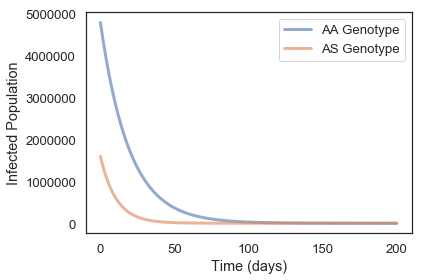

In [7]:
#makes a system object
system = make_system(0, 200, 1, #t_0, t_end, dt
                     1, #a
                     2.5e-6, #rN   6
                     40000000, #Nh
                     0.05, #θ1
                     0.06, #θ2
                     4.5e-7, #rV  7
                     0.05, #φ1
                     0.09, #φ1
                     10e6, #λh1
                     1.2e6,#λh2
                     0.08, #λm1
                     0.144, #λm2
                     0.07, #δm
                     4, #c
                     0.00003, #μ1
                     0.00005, #μ2
                     0.00002, #v
                     0.0001, #α1
                     0.00005, #α2
                     0.05, #γ1
                     0.09, #γ2
                     0.033, #bNh
                     0.4, #w
                     0.64, #P1
                     0.32) #P2
#runs simulation and plots the graph 
# condition where $0 spent on nets and $0 spent on vaccines
results = run_simulation(system, update_func, 0, 0) 
plot_results(results)
    

### Function With Money Spent
For this function, we set the money spent on nets and vaccines to 10,000,000,000 dollars. As you can see, the model does not show much of a difference from the one in which no money was spent. This was a shortcoming of our model. We go into more detail about this difficulty in the QMRI section. 

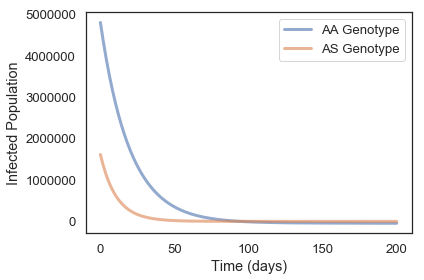

In [9]:
# makes a system object
system = make_system(0, 200, 1, #t_0, t_end, dt
                     1, #a
                     2.5e-6, #rN   6
                     40000000, #Nh
                     0.05, #θ1
                     0.06, #θ2
                     4.5e-7, #rV  7
                     0.05, #φ1
                     0.09, #φ1
                     10e6, #λh1
                     1.2e3,#λh2
                     0.08, #λm1
                     0.144, #λm2
                     0.07, #δm
                     4, #c
                     0.00003, #μ1
                     0.00005, #μ2
                     0.00002, #v
                     0.0001, #α1
                     0.00005, #α2
                     0.05, #γ1
                     0.09, #γ2
                     0.033, #bNh
                     0.4, #w
                     0.64, #P1
                     0.32) #P2
#runs simulation and plots the graph 
# condition where $100000000 spent on nets and $100000000 spent on vaccines
results = run_simulation(system, update_func, 10000000, 100000000) 
plot_results(results)
    

http://scholar.sun.ac.za/handle/10019.1/17989 (source of equations-you can download the full text by searching the web for "Modelling Malaria and Sickle Cell Gene. by Juliet Nakakawa Thesis" and it is currently the first result)

https://www.againstmalaria.com/dollarspernet.aspx (source of cost of malaria nets)

Note: We missed the documentation for our source for malaria net effectiveness because there were a lot of resources we consulted to find a good approximation as it varied quite a bit from source to source. In general, the consensus was that it reduced infection/biting rate by at least 50% however.

https://www.nejm.org/doi/full/10.1056/NEJMoa1515257 (source of efficacy of Malaria Vaccine)

https://gh.bmj.com/content/2/1/e000090 (Malaria Vaccine cost source)
https://journals.plos.org/plosmedicine/article?id=10.1371%2Fjournal.pmed.1001994 (Malaria Vaccine cost source)

